In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.special

In [2]:
def W_to_dBm(W):
    '''converts quantity in Watts to deciBel-milliWatts'''
    return (10*np.log10(W)) + 30

def dBm_to_W(dBm):
    '''converts quantity in deciBel-milliWatts to Watts'''
    return 10**((dBm - 30)/10)

# CRS calculations

Basic parameters of CRS:\
Sampling Rate = 3.2 Gsamples per second\
ADC Resolution = 14 bits\
ADC Samples per frame = 2^{14} = 16,384 samples\
Frame period = 16,384 S / 3.2 GSps = 5.12 microseconds\
Frequency Resolution = 3.2 GSps / 16,384 S = 195.3 kHz\
Min correlation period = 8192 * (16,384 S / 3.2 GSps) = 42 milleseconds


### Radiometer

Doing similar calculations but using CRS parameters, we get updated values.

the noise increased to 0.55 K

In [3]:
#ideal radiometer equation noise

Tsys = 50 #Kelvin
bandwidth = 195.3 *1e3 #Hz
int_time = 42 *1e-3 #seconds (integration time)
sigma_s = Tsys / np.sqrt(bandwidth*int_time) #Kelvin
print(sigma_s, 'K')

0.5520701140002003 K


For a telescope with a system temperature of 50 K, an integration time of 42 ms, and a channel with a bandwidth  of 195.3 kHz, the uncertainty or noise of the system is 0.55 K or ~0.6 K.

At 10$\sigma$ and 100$\sigma$ (in K), respectively

In [4]:
print(10*sigma_s)
print(100*sigma_s)

5.520701140002004
55.207011400020036


### Radiation temperature to Flux

Spectral Irradiance is still the same.

For a six-meter dish, the brightness temperature received from a 1-Jy source is 0.007 K or 7 mK.

In [5]:
#Brightness temperature per Spectral flux density or spectral irradiance

kB = 1.38e-23 #Boltzmann's constant in J/K
Jy = 1e-26 # unit of spectral flux density; Watts per square meter per Hz or Joules per square meter

radius = 3 #apperture radius in meters
ant_eff = 0.7 #antenna efficiency; unitless, from 0 to 1

K_per_Jy = ((ant_eff*np.pi*(radius)**2)*Jy)/(2*kB)
print(K_per_Jy, 'K/Jy')

0.0071710267092810484 K/Jy


So, how much spectral power in Jy or J/m^2 ( or W/m^2/Hz) is needed to raise the brightness temperature by 10 sigma? 100 sigma?

In [6]:
#in Jy
sigma_s
T10sigma = (10*sigma_s/K_per_Jy)
T100sigma = (100*sigma_s/K_per_Jy)
approx_T10sigma = (10*np.round(sigma_s,1)/0.007)
approx_T100sigma = (100*np.round(sigma_s,1)/0.007)
print('10σ:', T10sigma, 'Jy')
print('100σ:', T100sigma, 'Jy')
print('10σ (approx.):', approx_T10sigma, 'Jy')
print('100σ (approx.):', approx_T100sigma, 'Jy')

#in SI unit
T10sigma = (10*sigma_s/K_per_Jy)*Jy
T100sigma = (100*sigma_s/K_per_Jy)*Jy
approx_T10sigma = (10*np.round(sigma_s,1)/0.007)*Jy
approx_T100sigma = (100*np.round(sigma_s,1)/0.007)*Jy
print('10σ:', T10sigma, 'J/m^2')
print('100σ:', T100sigma, 'J/m^2')
print('10σ (approx.):', approx_T10sigma, 'J/m^2')
print('100σ (approx.):', approx_T100sigma, 'J/m^2')


10σ: 769.8620244792669 Jy
100σ: 7698.62024479267 Jy
10σ (approx.): 857.1428571428571 Jy
100σ (approx.): 8571.42857142857 Jy
10σ: 7.698620244792669e-24 J/m^2
100σ: 7.69862024479267e-23 J/m^2
10σ (approx.): 8.571428571428571e-24 J/m^2
100σ (approx.): 8.571428571428571e-23 J/m^2


The values with (approx.) are calculated by rounding off the spectral irradiance to 0.007 K/Jy and the $\sigma_{T}$
 to 0.6 K. This is just to show how much the estimation by rounding deviate when using the actual values.

### Farfield condition and flight altitude of the drone

In [7]:
def farfield_eqn(D, freq):
    'D in meters, freq in MHz'
    'returns farfield in meters'
    wl = 299.792/(freq)
    return 2*(D**2)/wl

In [8]:
print('Farfield distance (in meters) of a specific frequency for a six-meter dish')
print('425MHz:', farfield_eqn(6,425))
print('300MHz:', farfield_eqn(6,300))
print('400MHz:', farfield_eqn(6,400))
print('800MHz:', farfield_eqn(6,800))
print('1500MHz:', farfield_eqn(6,1500))

Farfield distance (in meters) of a specific frequency for a six-meter dish
425MHz: 102.07076906655281
300MHz: 72.04995463521375
400MHz: 96.066606180285
800MHz: 192.13321236057
1500MHz: 360.2497731760688


In [9]:
print('425 MHz:', farfield_eqn(6,425))
print('460 MHz:', farfield_eqn(6,460))
print('475 MHz:', farfield_eqn(6,475))
print('480 MHz:', farfield_eqn(6,480))


print('500 MHz:', farfield_eqn(6,500))
print('505 MHz:', farfield_eqn(6,505))
print('550 MHz:', farfield_eqn(6,550))

425 MHz: 102.07076906655281
460 MHz: 110.47659710732775
475 MHz: 114.07909483908844
480 MHz: 115.279927416342
500 MHz: 120.08325772535626
505 MHz: 121.28409030260983
550 MHz: 132.0915834978919


In [9]:
print('705 MHz:', farfield_eqn(6,705))

705 MHz: 169.31739339275234


In [10]:
#What frequency should I look?

samp_rate = 3.2e9
adc_samps = 2**14
freq_res = samp_rate/adc_samps
freq_res

195312.5

In [11]:
chord_freq_bw = 1200e6
chord_freq_bw/freq_res

6144.0

In [10]:
altitude = 120
SA = 4*np.pi*(altitude**2)
bw = 195.3 *1e3
Pw10s_SI = T10sigma*bw* SA
Pw100s_SI = T100sigma*bw* SA
approx_Pw10s_SI = approx_T10sigma*bw* SA
approx_Pw100s_SI = approx_T100sigma*bw* SA

print('Required power of the drone to raise the temperature by 10σ or 100σ at {} m AGL and bandwidth of 195.3 kHz'.format(altitude))
print('10σ:', W_to_dBm(Pw10s_SI), 'dBm')
print('100σ:', W_to_dBm(Pw100s_SI), 'dBm')
print('10σ (approx.):', W_to_dBm(approx_Pw10s_SI), 'dBm')
print('100σ (approx.):', W_to_dBm(approx_Pw100s_SI), 'dBm')

Required power of the drone to raise the temperature by 10σ or 100σ at 120 m AGL and bandwidth of 195.3 kHz
10σ: -95.65312503184157 dBm
100σ: -85.65312503184157 dBm
10σ (approx.): -95.18672190225413 dBm
100σ (approx.): -85.18672190225413 dBm


In [11]:
#The amount of power at the focus is 
W_to_dBm((Pw100s_SI/SA)*(np.pi*(radius**2)))

-123.71492477168044

In [12]:
#For the sidelobe mapping, I need to increase the power output of the calibrator. If I add 30 dB, then I get
W_to_dBm(((dBm_to_W((W_to_dBm(Pw100s_SI)+30)))/SA)*(np.pi*(radius**2)))

-93.71492477168044

### RFI considerations of the drone

In [13]:
def calc_power_at_focus(agl, dish_radius, pw_emit):
    '''
    Calculate power collected by the dish and focused at the feed, emitted from the drone source flying directly over the dish at a height
    agl = height of drone flight over the dish in meters
    dish_radius = dish radius in meters
    pw_emit = power of the emitted by the drone calibration source in Watts
    CA_dish = collecting area of the dish 
    SA_radiated = surface area of the imaginary sphere whose radius is the distance between the drone source and dish
    '''
    
    CA_dish = np.pi*dish_radius**2
    SA_radiated = 4*np.pi*agl**2
    noise_flux = pw_emit/SA_radiated

    return noise_flux*CA_dish

#reverse process of calc_power_at_focus
def calc_power_emitted(agl, dish_radius, pw_focus):
    '''
    Calculate power emitted from the drone source flying directly over the dish at a height based on the power at the focus or feed
    agl = height of drone flight over the dish in meters
    dish_radius = dish radius in meters
    pw_emit = power of the emitted by the drone calibration source in Watts
    CA_dish = collecting area of the dish 
    SA_radiated = surface area of the imaginary sphere whose radius is the distance between the drone source and dish
    '''

    
    CA_dish = np.pi*dish_radius**2
    SA_radiated = 4*np.pi*agl**2
    noise_flux = pw_focus/CA_dish

    return noise_flux*SA_radiated

In [14]:
#checking the table from https://ardupilot.org/copter/docs/common-3dr-radio-advanced-configuration-and-technical-information.html
#for actual values
drone_915_pw = np.array([1., 2., 5., 8., 11., 14., 17., 20.]) #power in dBm
drone_915_pw_mW = np.array([1.3,1.6,3.2,6.3,12.5,25,50,100])/1000
W_to_dBm(drone_915_pw_mW)

array([ 1.13943352,  2.04119983,  5.05149978,  7.99340549, 10.96910013,
       13.97940009, 16.98970004, 20.        ])

In [16]:
altitude = 200
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('200 AGL:',ant_power_mat)

altitude = 120
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('120 AGL:',ant_power_mat)

200 AGL: [-41.49877473 -40.49877473 -37.49877473 -34.49877473 -31.49877473
 -28.49877473 -25.49877473 -22.49877473]
120 AGL: [-37.06179974 -36.06179974 -33.06179974 -30.06179974 -27.06179974
 -24.06179974 -21.06179974 -18.06179974]


Using the -25dBm as the upper limit reference, the telemetry power should be set at 14 dBM max limit when flying at 200m AGL

In [33]:
altitude = 50
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('50m AGL:',ant_power_mat)

altitude = 15
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('15m AGL:',ant_power_mat)

50m AGL: [-29.45757491 -28.45757491 -25.45757491 -22.45757491 -19.45757491
 -16.45757491 -13.45757491 -10.45757491]
15m AGL: [-19. -18. -15. -12.  -9.  -6.  -3.   0.]


In [ ]:
altitude = 50
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('50m AGL:',ant_power_mat)

altitude = 15
ant_power_mat = np.zeros_like(drone_915_pw)
for i in range(len(drone_915_pw)):
    ant_power_mat[i] = W_to_dBm(calc_power_at_focus(altitude,radius, dBm_to_W(drone_915_pw[i])))
print('15m AGL:',ant_power_mat)

### Mapping the uncertainty

In [17]:
print('Sample Calculation')

Tsys = 50 #Kelvin
bandwidth = 1200e6 #Hz
int_time = 42e-3 #seconds (integration time)
sigma_s = Tsys / np.sqrt(bandwidth*int_time) #Kelvin
print('50K-sigma:', sigma_s, 'K')
sigma0 = sigma_s

Tsys = 90 #Kelvin
bandwidth = 195.3e3 #Hz
int_time = 42e-3 #seconds (integration time)
sigma_s = Tsys / np.sqrt(bandwidth*int_time) #Kelvin
print('90K-sigma:',sigma_s, 'K')

print('Uncertainty for raising temperature by 40K')
sigma = np.sqrt(sigma0**2 + sigma_s**2)
print('new sigma:',sigma, 'K')
print('fractional:',(sigma/40)*100, '%') #newTsys - Tsys = 90 - 50 = 40K

Sample Calculation
50K-sigma: 0.007042952122737638 K
90K-sigma: 0.9937262052003606 K
Uncertainty for raising temperature by 40K
new sigma: 0.9937511630566841 K
fractional: 2.48437790764171 %


/tmp/ipykernel_91154/1300800510.py:15: RuntimeWarning: divide by zero encountered in divide
  fractional_uncertainty = uncertainty_T_mat/delta_T_mat


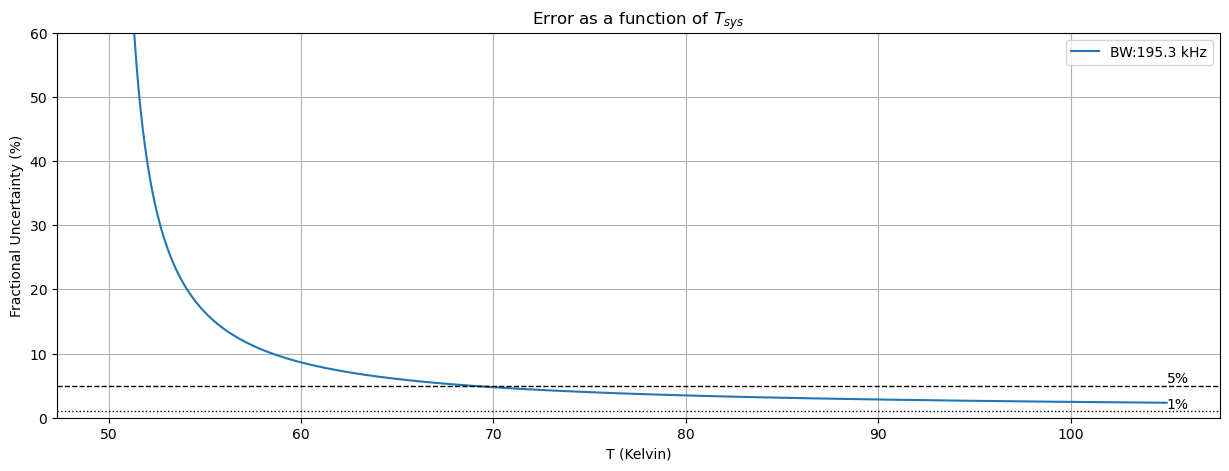

In [18]:
#Tsys = 50K; Tsys+40 = 90K
Tsys = 50
T_mat = np.linspace(Tsys,Tsys + 55,1001) 

int_time = 42e-3 #seconds (integration time)

#radiometer equation
sigma_T_mat = T_mat/np.sqrt(bandwidth*int_time)

#error propagation
uncertainty_T_mat = np.sqrt(sigma_T_mat[0]**2 + sigma_T_mat**2)
#added temperature
delta_T_mat = T_mat - T_mat[0]

fractional_uncertainty = uncertainty_T_mat/delta_T_mat
plt.figure(figsize=(15,5))
plt.plot(T_mat, fractional_uncertainty*100, label = 'BW:195.3 kHz')
plt.ylim(0,60)

plt.title('Error as a function of $T_{sys}$')
plt.xlabel('T (Kelvin)')
plt.ylabel('Fractional Uncertainty (%)')
plt.axhline(1,c='black', linestyle=':', linewidth=1)
plt.text(105,1.5,'1%',rotation=0)
plt.axhline(5,c='black', linestyle='--', linewidth=1)
plt.text(105,5.5,'5%',rotation=0)
plt.legend(loc=1)
plt.grid()
plt.show()
frac_check390 = fractional_uncertainty
#supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

In [19]:
altitude = 120
#for a 120m x 120m grid
(np.arctan(60/altitude))*180/np.pi

26.56505117707799

In [20]:
#for a 60m x 600 grid
(np.arctan(30/altitude))*180/np.pi

14.036243467926477

In [21]:
lambda_wl = 3e8/475e6 
D = 6
np.rad2deg(1.22*lambda_wl/D)

7.357984316416887

For a source at 475 MHz, beamwidth (first null to first null) is +/- 7.36 or ~7\
Flying at 120 m AGL, the approximate angular coverage is +/- 26.6 degrees for a 120m x 120m grid while +/- 14.0 degrees for a 60m x 60m grid

/tmp/ipykernel_91154/826342760.py:16: RuntimeWarning: invalid value encountered in divide
  airy_2D = (2 * scipy.special.j1(rr) / rr)**2


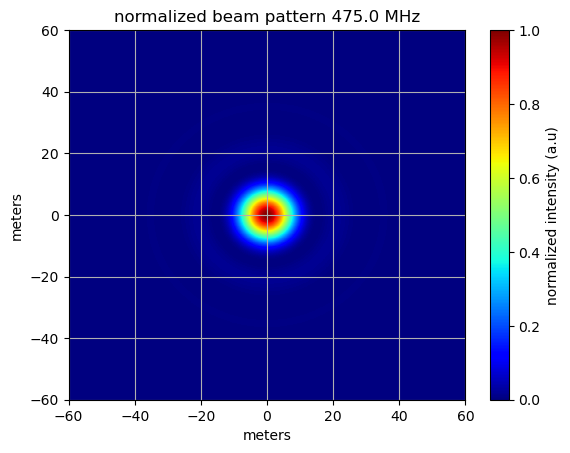

In [23]:
xlim = 60 #for a 120m x 120m grid
x = np.linspace(-xlim, xlim, 1201)
y=x
freq = 475e6
lambda_wl = 3e8/freq 
D = 6
#sigma = 1.22*lambda_wl/D
#R = scipy.special.jn_zeros(1, 1)/np.pi
#R = 1
xx, yy = np.meshgrid(x, y)
altitude = 120

q = np.sqrt((xx**2) + (yy**2))
R = np.sqrt((xx**2) + (yy**2) + altitude**2)
rr = (np.pi*D/lambda_wl)*q/R
airy_2D = (2 * scipy.special.j1(rr) / rr)**2

#correction for RuntimeWarning: invalid value encountered in true_divide
#at (0,0), the intensity should 1
searchval = 0
ii =np.array( np.where(q == searchval))
airy_2D[ii[0][0]][ii[1][0]] = 1

#plt.pcolormesh(xx,yy,airy_2D, cmap='turbo', norm=colors.LogNorm(vmin=airy_2D.min(), vmax=airy_2D.max()))
# xx = (np.arctan(xx/altitude))*180/np.pi
# yy = (np.arctan(yy/altitude))*180/np.pi
plt.pcolormesh(xx,yy,airy_2D, cmap='jet')
plt.title('normalized beam pattern {} MHz'.format(freq/1e6))
plt.colorbar(label='normalized intensity (a.u)')
plt.grid()
lim_deg = 60
plt.xlim(-lim_deg,lim_deg)
plt.ylim(-lim_deg,lim_deg)
plt.xlabel('meters')
plt.ylabel('meters')
plt.show()

/tmp/ipykernel_91154/1483343088.py:16: RuntimeWarning: invalid value encountered in divide
  airy_2D = (2 * scipy.special.j1(rr) / rr)**2


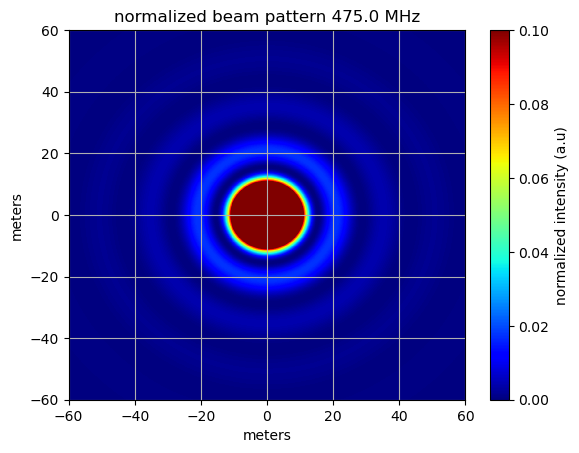

In [24]:
xlim = 60 #for a 120m x 120m grid
x = np.linspace(-xlim, xlim, 1201)
y=x
freq = 475e6
lambda_wl = 3e8/freq 
D = 6
#sigma = 1.22*lambda_wl/D
#R = scipy.special.jn_zeros(1, 1)/np.pi
#R = 1
xx, yy = np.meshgrid(x, y)
altitude = 120

q = np.sqrt((xx**2) + (yy**2))
R = np.sqrt((xx**2) + (yy**2) + altitude**2)
rr = (np.pi*D/lambda_wl)*q/R
airy_2D = (2 * scipy.special.j1(rr) / rr)**2

#correction for RuntimeWarning: invalid value encountered in true_divide
#at (0,0), the intensity should 1
searchval = 0
ii =np.array( np.where(q == searchval))
airy_2D[ii[0][0]][ii[1][0]] = 1

#plt.pcolormesh(xx,yy,airy_2D, cmap='turbo', norm=colors.LogNorm(vmin=airy_2D.min(), vmax=airy_2D.max()))
# xx = (np.arctan(xx/altitude))*180/np.pi
# yy = (np.arctan(yy/altitude))*180/np.pi
plt.pcolormesh(xx,yy,airy_2D, cmap='jet', vmax=0.1)
plt.title('normalized beam pattern {} MHz'.format(freq/1e6))
plt.colorbar(label='normalized intensity (a.u)')
plt.grid()
lim_deg = 60
plt.xlim(-lim_deg,lim_deg)
plt.ylim(-lim_deg,lim_deg)
plt.xlabel('meters')
plt.ylabel('meters')
plt.show()

In [25]:
altitude = 120 
bandwidth = 195.3e3
addT_sys = 40
T_S_ratio = K_per_Jy/Jy

P_n = (addT_sys / T_S_ratio) * bandwidth * (4*np.pi*(altitude**2)) 
print(P_n)

1.9713024e-12


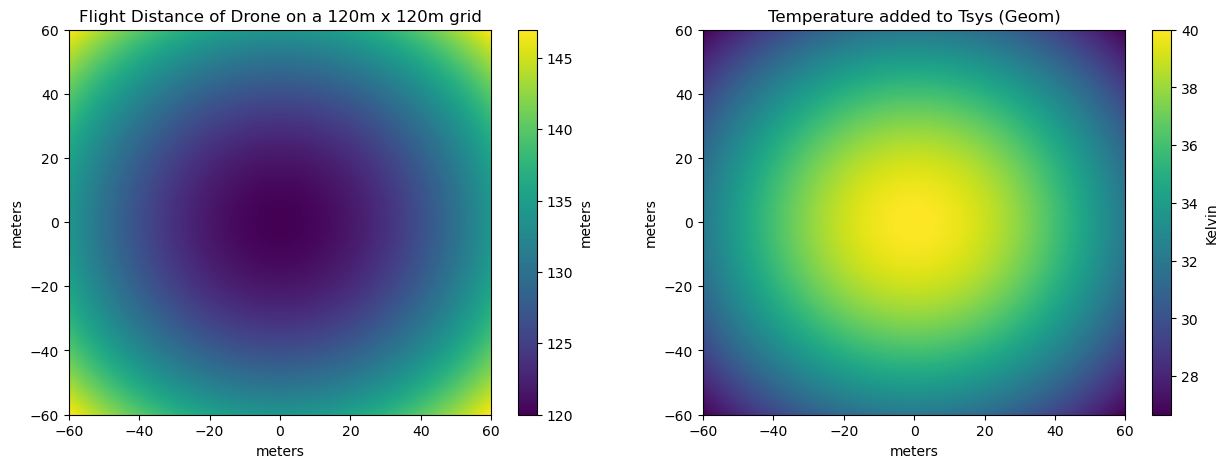

In [26]:
x = np.linspace(-60,60,1201)
y = x

X,Y = np.meshgrid(x,y)
dr_dist = np.sqrt((X**2)+(Y**2)+(altitude**2))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.pcolormesh(X,Y,dr_dist)
plt.colorbar(label='meters')
plt.title('Flight Distance of Drone on a 120m x 120m grid')
plt.xlabel('meters')
plt.ylabel('meters')



T_raised = P_n * T_S_ratio / (bandwidth * (4*np.pi*(dr_dist**2)))
plt.subplot(1,2,2)
plt.pcolormesh(X,Y,T_raised)
plt.colorbar(label='Kelvin')
plt.title('Temperature added to Tsys (Geom)')
plt.xlabel('meters')
plt.ylabel('meters')
plt.show()


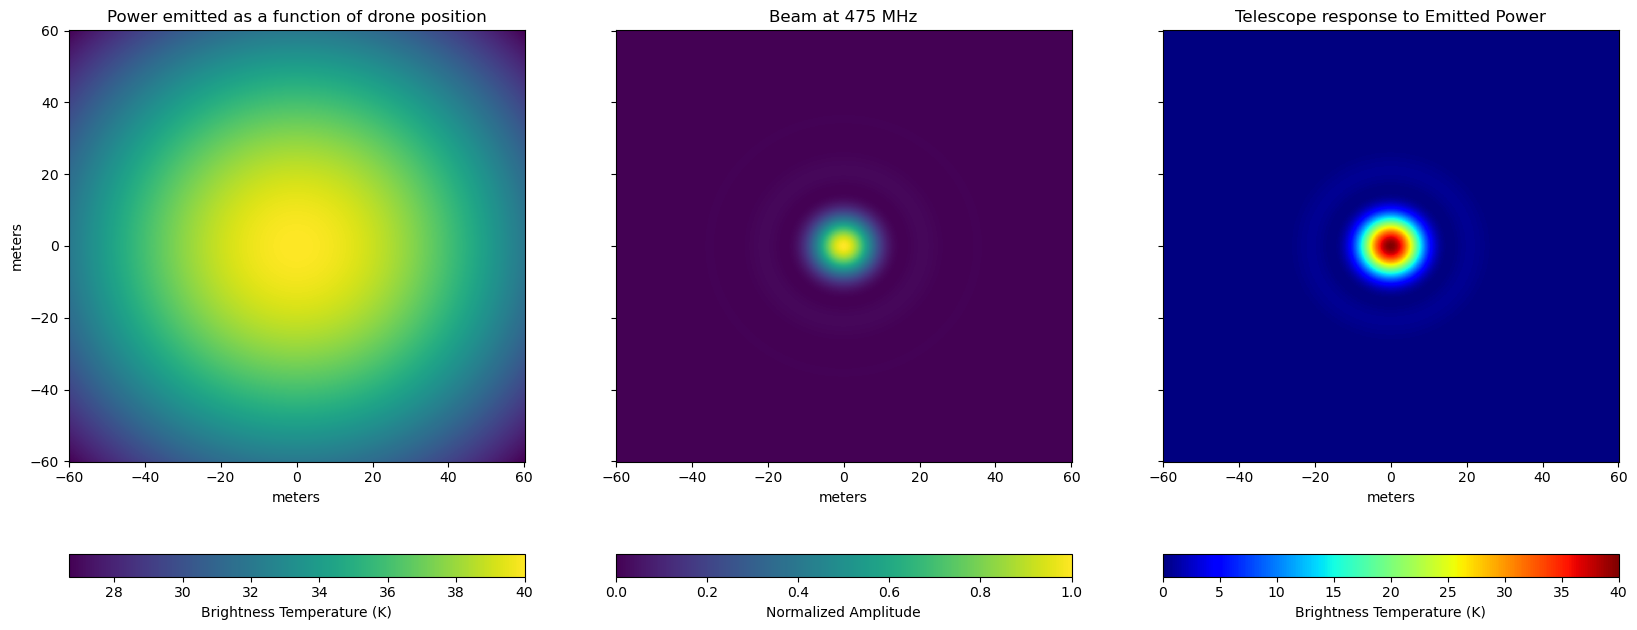

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.pcolormesh(X,Y,T_raised)
plt.colorbar(orientation='horizontal', label='Brightness Temperature (K)')
plt.xlabel('meters')
plt.ylabel('meters')
plt.title('Power emitted as a function of drone position')

plt.subplot(1,3,2)
plt.pcolormesh(X,Y,airy_2D)
plt.colorbar(orientation='horizontal', label='Normalized Amplitude')
plt.xlabel('meters')
plt.tick_params(labelleft=False)
plt.title('Beam at 475 MHz')


plt.subplot(1,3,3)
beam_response = T_raised*airy_2D
plt.pcolormesh(X,Y, beam_response, cmap='jet')
plt.colorbar(orientation='horizontal', label='Brightness Temperature (K)')
plt.xlabel('meters')
plt.tick_params(labelleft=False)
plt.title('Telescope response to Emitted Power')

plt.show()

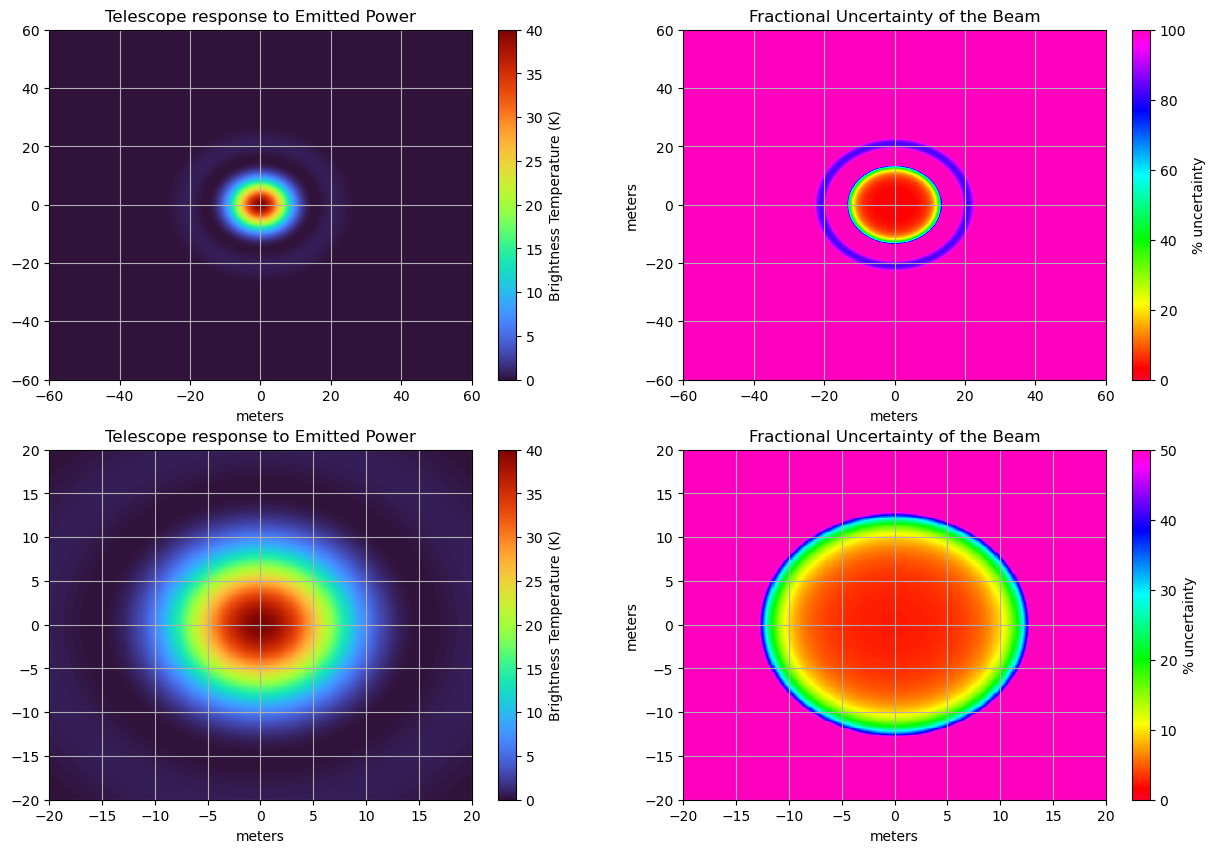

In [28]:
x = np.linspace(-60,60,1201)
y = x

Tsys = 50
bandwidth = 1200e6 #Hz
int_time = 42 *1e-3 #seconds (integration time)
sigma_Tsys = Tsys / np.sqrt(bandwidth*int_time) 

bandwidth = 195.3e3
X,Y = np.meshgrid(x,y)
dr_dist = np.sqrt((X**2)+(Y**2)+(altitude**2)) #drone distance
T_raised = P_n * T_S_ratio / (bandwidth * (4*np.pi*(dr_dist**2)))
T_raised = T_raised*airy_2D
T_mat = T_raised + Tsys

sigma_T_mat = T_mat/np.sqrt(bandwidth*int_time)

uncertainty_T_mat = np.sqrt(sigma_Tsys**2 + sigma_T_mat**2)
delta_T_mat = T_mat - Tsys

fractional_uncertainty = uncertainty_T_mat/T_raised
#plt.figure(figsize=(15,5))
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.pcolormesh(X,Y, beam_response, cmap='turbo')
#plt.pcolormesh(X,Y, beam_response, norm=colors.LogNorm(vmin=1e-1, vmax=beam_response.max()), cmap='jet')
#plt.pcolormesh(X,Y, 10*np.log10(beam_response), cmap='jet')
#plt.pcolormesh(X,Y, 10*np.log10(beam_response), norm=colors.LogNorm(vmin=1e-1, vmax=beam_response.max()), cmap='jet')
plt.colorbar(label='Brightness Temperature (K)')
plt.xlabel('meters')
plt.grid()
plt.title('Telescope response to Emitted Power')

plt.subplot(2,2,2)
plt.pcolormesh(X,Y,fractional_uncertainty*100,vmin=0, vmax=100, cmap='gist_rainbow')
#plt.pcolormesh(X,Y,T_mat,cmap='gist_rainbow')
plt.colorbar(label='% uncertainty')
plt.title('Fractional Uncertainty of the Beam')
plt.xlabel('meters')
plt.ylabel('meters')
plt.grid()



plt.subplot(2,2,3)
plt.pcolormesh(X,Y, beam_response, cmap='turbo')
#plt.pcolormesh(X,Y, beam_response, norm=colors.LogNorm(vmin=1e-1, vmax=beam_response.max()), cmap='jet')
#plt.pcolormesh(X,Y, 10*np.log10(beam_response), cmap='jet')
#plt.pcolormesh(X,Y, 10*np.log10(beam_response), norm=colors.LogNorm(vmin=1e-1, vmax=beam_response.max()), cmap='jet')
plt.colorbar(label='Brightness Temperature (K)')
plt.xlabel('meters')
plt.grid()
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Telescope response to Emitted Power')

plt.subplot(2,2,4)
plt.pcolormesh(X,Y,fractional_uncertainty*100,vmin=0, vmax=50, cmap='gist_rainbow')
#plt.pcolormesh(X,Y,T_mat,cmap='gist_rainbow')
plt.colorbar(label='% uncertainty')
plt.title('Fractional Uncertainty of the Beam')
plt.xlabel('meters')
plt.ylabel('meters')
plt.grid()
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.show()

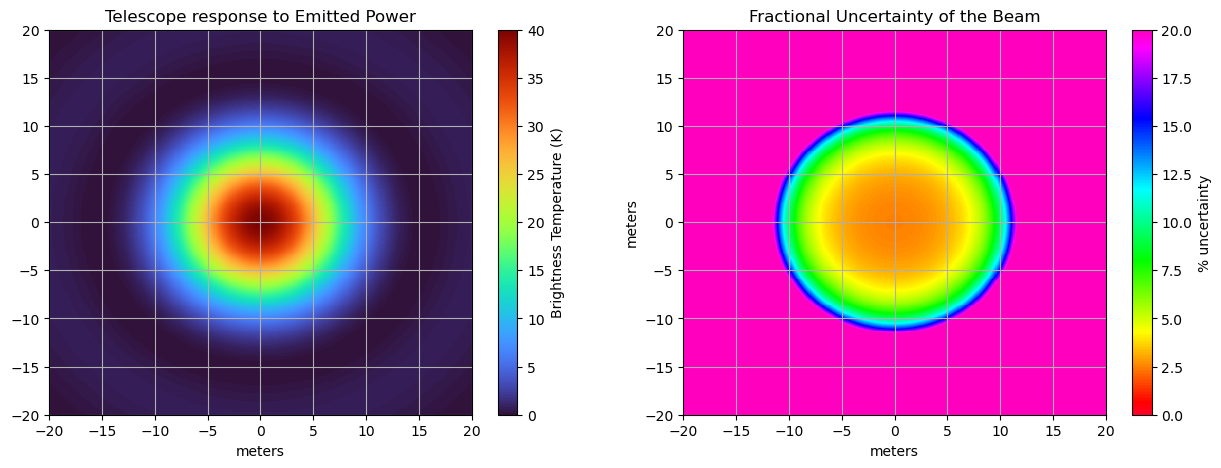

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.pcolormesh(X,Y, beam_response, cmap='turbo')
plt.colorbar(label='Brightness Temperature (K)')
plt.xlabel('meters')
plt.title('Telescope response to Emitted Power')
plt.grid()
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.subplot(1,2,2)

plt.pcolormesh(X,Y,fractional_uncertainty*100,vmin=0, vmax=20, cmap='gist_rainbow')
plt.colorbar(label='% uncertainty')
plt.title('Fractional Uncertainty of the Beam')
plt.xlabel('meters')
plt.ylabel('meters')
plt.grid()
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.show()